## An introduction to Genetic Algorithms

Following example from this paper: https://arxiv.org/pdf/1308.4675

### The problem

Find $a$, $b$, $c$ and $d$ such that they satisfy the equality $a + 2b + 3c + 4d = 30$.

We formualte our objective function as $$f(x) = (a + 2b + 3c + 4d) - 30$$

Since there are four variables in the function, we can compose the chromosome as with the genes a, b, c and d. For simplicity, we restrict the values these can take to the range $[0, 30]$.

In [ ]:
import numpy as np

population_size = 6

chromosomes = []

## initialization
for _ in range(population_size):
    chromosomes.append([np.random.randint(0, 30 + 1) for _ in range(4)])

print(chromosomes)

[[6, 19, 28, 14], [10, 7, 28, 20], [6, 25, 18, 22], [10, 10, 23, 20], [3, 7, 23, 2], [21, 20, 1, 23]]


In [129]:
## evaluation
def objective_fn(a, b, c, d):
    return abs((a + 2 * b + 3 * c + 4 * d) - 30)


scores = [objective_fn(*x) for x in chromosomes]
print(scores)

[154, 158, 168, 149, 64, 126]


In [130]:
def fitness(val: int):
    return 1 / (val + 1)


total_fitness = sum([fitness(x) for x in scores])
print(f"Total fitness: {total_fitness}")

Total fitness: 0.04858337864195359


Probability for getting selected next generation of chromosomes for a chromosome $i$ = $\dfrac{\text{Fitness[i]}}{\text{Total Fitness}}$


In [131]:
probas = [fitness(x) / total_fitness for x in scores]
cumprobas = np.cumsum(probas)

rands = np.random.random(population_size)


def get_chromosome(r):
    for i, cumproba in enumerate(cumprobas):
        if cumproba > r:
            return chromosomes[i]


new_chromosomes = [get_chromosome(r) for r in rands]

print(new_chromosomes)


[[3, 7, 23, 2], [10, 7, 28, 20], [10, 7, 28, 20], [10, 7, 28, 20], [6, 25, 18, 22], [3, 7, 23, 2]]


In [132]:
crossover_rate = 0.25

crossover_chromosomes_idx = [
    i for i, _ in enumerate(new_chromosomes) if rands[i] < crossover_rate
]

crossover_points = [
    np.random.randint(0, len(chromosomes[x])) for x in crossover_chromosomes_idx
]


In [133]:
import copy


def crossover(chromosomes, crossover_chromosomes_idx, crossover_points):
    # There are a total of nC2 possible pairs
    result = copy.deepcopy(chromosomes)
    for i, chromosome_idx in enumerate(
        crossover_chromosomes_idx[: len(crossover_chromosomes_idx)]
    ):
        chr_one = chromosome_idx
        for chr_two in crossover_chromosomes_idx[i + 1 :]:
            crossover_point = crossover_points.pop(0)
            result[chr_one] = (
                chromosomes[chr_one][:crossover_point]
                + chromosomes[chr_two][crossover_point:]
            )

    return result  # returns complete list of cross-overed chromosomes


crossed_chromosomes = crossover(
    new_chromosomes, crossover_chromosomes_idx, crossover_points
)

In [134]:
mutation_rate = 10
mutated_chromosomes = []

for cross_chrm in crossed_chromosomes:
    chrm_copy = cross_chrm[:]  # shallow copy of chromosome
    if mutation_rate < np.random.randint(4 * population_size):
        chrm_copy[np.random.randint(0, 4)] = np.random.randint(0, 30 + 1)
    mutated_chromosomes.append(chrm_copy)

print(crossed_chromosomes)
print(mutated_chromosomes)

[[3, 7, 23, 2], [10, 7, 28, 20], [10, 7, 28, 20], [10, 7, 28, 20], [6, 25, 18, 22], [3, 7, 23, 2]]
[[3, 7, 23, 2], [10, 14, 28, 20], [10, 7, 29, 20], [10, 7, 28, 22], [6, 25, 18, 22], [3, 7, 23, 2]]


Now do this repeatedly for ~50 (or whatever number pleases you) times. Then _maybe_ you will get a solution.

We put together into an easy-to-call function.

In [54]:
# for convenience
import numpy as np
import copy


def initialization(population_size, n_alleles):
    chromosomes = []
    for _ in range(population_size):
        chromosomes.append([np.random.randint(0, 30 + 1) for _ in range(n_alleles)])
    return chromosomes


# The objective function
def score(fn, target, alleles):
    return abs(fn(*alleles) - target)


# Same as before; putting here for convenience
def fitness(val: int):
    return 1 / (val + 1)


# Get the chromosome for a new population of chromosomes
def get_chromosome(r, cumprobas, chromosomes):
    for i, cumproba in enumerate(cumprobas):
        if cumproba > r:
            return chromosomes[i]


def crossover(chromosomes, crossover_chromosomes_idx, crossover_points):
    # There are a total of nC2 possible pairs
    result = copy.deepcopy(chromosomes)
    for i, chromosome_idx in enumerate(
        crossover_chromosomes_idx[: len(crossover_chromosomes_idx)]
    ):
        chr_one = chromosome_idx
        crossover_point = crossover_points[i]
        for chr_two in crossover_chromosomes_idx[i + 1 :]:
            result[chr_one] = (
                chromosomes[chr_one][:crossover_point]
                + chromosomes[chr_two][crossover_point:]
            )

    return result  # returns complete list of cross-overed chromosomes


def mutation(mutation_rate, chromosomes, target, n_alleles, population_size):
    mutated_chromosomes = []
    for cross_chrm in chromosomes:
        chrm_copy = cross_chrm[:]  # shallow copy of chromosome
        if mutation_rate < np.random.randint(n_alleles * population_size):
            chrm_copy[np.random.randint(0, n_alleles)] = np.random.randint(
                0, target + 1
            )
        mutated_chromosomes.append(chrm_copy)
    return mutated_chromosomes


# The final function
def solve(
    population_size,
    n_alleles,
    objective_fn,
    target,
    crossover_rate=0.25,
    mutation_rate=10,
    iters=10,
):
    chromosomes = initialization(population_size, n_alleles)
    results = []
    for i in range(iters):
        scores = [score(objective_fn, target, x) for x in chromosomes]
        total_fitness = sum([fitness(x) for x in scores])
        probas = [fitness(x) / total_fitness for x in scores]
        cumprobas = np.cumsum(probas)
        rands = np.random.random(population_size)
        # the new candidate population (yet to go through crossover and mutation)
        new_chromosomes = [get_chromosome(r, cumprobas, chromosomes) for r in rands]
        # chromosomes to be crossed-over in the new population
        crossover_chromosomes_idx = [
            i for i, _ in enumerate(new_chromosomes) if rands[i] < crossover_rate
        ]
        # crossover points in the chromosomes to be crossed-over
        crossover_points = [
            np.random.randint(0, n_alleles) for _ in crossover_chromosomes_idx
        ]
        # using the crossover function from before;
        # this is the new population after performing cross over
        crossed_chromosomes = crossover(
            new_chromosomes, crossover_chromosomes_idx, crossover_points
        )
        # mutating random parts of the new population
        mutated_chromosomes = mutation(
            mutation_rate, crossed_chromosomes, target, n_alleles, population_size
        )
        results.append(mutated_chromosomes)
        # print(f"Iteration {i + 1}: {mutated_chromosomes}")
    # print("-" * 4)
    # print("Scores for the last batch:")
    scores = []
    for chr in results[-1]:
        chr_score = score(objective_fn, target, chr)
        scores.append(chr_score)
        # print(f"{chr}: {chr_score}")
    return min(scores)

Running 50 iterations...

In [52]:
def fn(a, b, c, d):
    return a + 2 * b + 3 * c + 4 * d


solve(population_size=6, n_alleles=4, target=30, objective_fn=fn, iters=20)

Scores for the last batch:
[15, 4, 10, 2]: 31
[15, 4, 1, 2]: 4
[15, 4, 1, 2]: 4
[29, 12, 17, 0]: 74
[15, 12, 1, 2]: 20
[15, 4, 1, 2]: 4


Text(0, 0.5, 'Best score in the population')

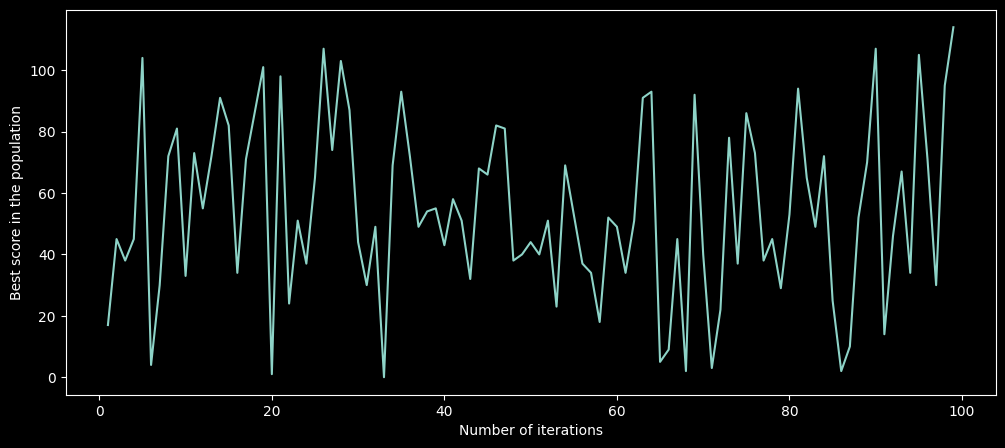

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
xs = np.arange(1, 100)
ys = [
    solve(population_size=6, n_alleles=4, target=30, objective_fn=fn, iters=x)
    for x in xs
]

plt.plot(xs, ys)
plt.xlabel("Number of iterations")
plt.ylabel("Best score in the population")